In [493]:
import pandas as pd
import datetime
import numpy as np
import torch
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Concatenate, Add, Masking, GRU, RepeatVector, Dot, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MAE, MSE, RootMeanSquaredError, Recall, Precision, Accuracy, CategoricalAccuracy
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
#import csv
merged_df = pd.read_csv('merged_treated_2000_with_missing.csv', index_col=0)

#add key for DB later
merged_df['key'] = merged_df['name'] + '-' + merged_df['year'].astype('str') + '-' + merged_df['race_name']

#pd date time
merged_df['date'] = pd.to_datetime(merged_df['date'])

def change_bin(x):
    if x == 0:
        return -1000.
    elif x < 21:
        return 1.
    elif x < 41:
        return 2.
    else:
        return 3
    
merged_df['result_bin'] = merged_df['result'].apply(change_bin)
print(merged_df.shape)
merged_df = merged_df[merged_df['result_bin'] != -1000.]
print(merged_df.shape)

def get_types_bin(x):
    if x == 'etappe':
        return 0
    else:
        return 1
    
def icon_bin(x):
    if x == 'stage':
        return 0
    else:
        return 1
    
merged_df['types_bin'] = merged_df['type'].apply(get_types_bin)
merged_df['icon_bin'] = merged_df['icon'].apply(icon_bin)


#split to predict later
merged_df_predict = merged_df[merged_df['year'] == 2022]
merged_df_train = merged_df[merged_df['year'] != 2022]

merged_df.shape

(346089, 28)
(331614, 28)


(331614, 30)

In [4]:
merged_df.type.value_counts()

etappe     309526
one_day     22088
Name: type, dtype: int64

In [5]:
#riders to predict
riders_predict = merged_df_predict[(merged_df_predict['race_name']=='tour-de-france')| (merged_df_predict['race_name']=='vuelta-a-espana')| (merged_df_predict['race_name']=='giro-d-italia')][['name', 'year', 'race_name']]
riders_predict = riders_predict[riders_predict['year'] == 2022].drop_duplicates().reset_index(drop=True)
riders_predict

,name,year,race_name
0,tadej-pogacar,2022,tour-de-france
1,mikkel-bjerg,2022,tour-de-france
2,rafal-majka,2022,tour-de-france
3,brandon-mcnulty,2022,tour-de-france
4,marc-soler,2022,tour-de-france
...,...,...,...
347,sergio-samitier,2022,giro-d-italia
348,filippo-fiorelli,2022,giro-d-italia
349,jakub-mareczko,2022,giro-d-italia
350,miguel-angel-lopez,2022,giro-d-italia


In [6]:
#riders to train on
riders = merged_df_train[(merged_df_train['race_name']=='tour-de-france')| (merged_df_train['race_name']=='vuelta-a-espana')| (merged_df_train['race_name']=='giro-d-italia')][['name', 'year', 'race_name']]
riders = riders[riders['year'] != 2022].drop_duplicates().reset_index(drop=True).sort_values(by='year', ascending=False)
riders

,name,year,race_name
4366,frederik-frison,2021,vuelta-a-espana
3997,jack-haig,2021,tour-de-france
4003,bauke-mollema,2021,giro-d-italia
4002,vincenzo-nibali,2021,giro-d-italia
4001,dan-martin,2021,giro-d-italia
...,...,...,...
6636,mauro-zanetti,2000,giro-d-italia
6635,massimo-donati,2000,giro-d-italia
6634,francesco-casagrande,2000,giro-d-italia
6633,francesco-secchiari,2000,giro-d-italia


In [8]:
#split riders in train/test randomly
train, test = train_test_split(riders, test_size=0.2, random_state=42)

#split rediers in train/test based on years
train = riders[riders['year']<2019]
test = riders[riders['year']>=2019]

len(test)/len(train)

0.16666666666666666

In [9]:
#function to get sequence
def get_sequence(df, name, year, tour, weeks=104):
    
    if year != 2000:
        #decoder data = 21 days of the tour
        tour_data = df[(df['name'] == name) & (df['year'] == year) & (df['race_name'] == tour)].sort_values(by='date')
        y_decoder = tour_data[['date', 'result']].set_index('date')
        X_decoder = tour_data[['date', 'distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']].set_index('date')
        
        #encoder data = x weeks before tour to make prediction
        season_data = df[(df['name'] == name) & (df['date'] < min(tour_data['date'])) & (df['date'] >= min(tour_data['date']) - datetime.timedelta(weeks=weeks))].sort_values(by='date')
        X_encoder = season_data[['date', 'distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num', 'adjusted_points']]
        performance = X_encoder.pivot_table('adjusted_points', 'date','parcours_type_num').shift(1).fillna(0).cumsum().reset_index()
        X_encoder = performance.merge(X_encoder, on='date').set_index('date').drop(columns='adjusted_points').rename(columns={1.0 : 'fl', 2.0:'hi_fl', 3.0: 'hi_hi', 4.0:'mo_fl', 5.0:'mo_mo'})
        
        for i in ['fl', 'hi_fl', 'hi_hi', 'mo_fl', 'mo_mo']:
            if i not in X_encoder.columns:
                X_encoder[i] = 0.0
        X_encoder = X_encoder[['fl', 'mo_fl', 'hi_fl', 'hi_hi', 'mo_mo', 'distance', 'ProfileScore:','Vert. meters:', 'Startlist quality score:', 'parcours_type_num']]
                
        y_encoder = season_data[['date', 'result']].set_index('date')
        
    return X_encoder, X_decoder, y_decoder, y_encoder

In [10]:
#X_encoder, X_decoder, y_decoder, y_encoder = get_sequence(merged_df, 'gianni-moscon', 2017, 'vuelta-a-espana', weeks=104)

In [10]:
# function to get sequences for each rider + pad + put in array
def get_sequences(maxlen, df, riders):
    
    X_encoder_ls = []
    X_decoder_ls = []
    y_encoder_ls = []
    y_decoder_ls = []
    
    i=0


    for rider, year, tour in riders.values:
        
        if year != 2000:
            
            #print(rider, year, tour)
            
            try:
            
                #X_encoder, X_decoder, y = get_sequence(df, rider, year, tour)
                X_encoder, X_decoder, y_decoder, y_encoder = get_sequence(df, rider, year, tour)
                
                X_encoder = X_enc_mm.transform(X_encoder)
                X_decoder = X_dec_mm.transform(X_decoder)
                #y = y_train_mm.transform(y)
                
                X_encoder_pad = pad_sequences(X_encoder.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                y_encoder_pad = pad_sequences(y_encoder.to_numpy().T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                
                X_decoder_pad = pad_sequences(X_decoder.T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                y_decoder_pad = pad_sequences(y_decoder.to_numpy().T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                #X_decoder_pad = pad_sequences(X_decoder_pad.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                
                #y_decoder_pad = pad_sequences(y_decoder.T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                #y_pad = pad_sequences(y_decoder_pad.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                    
                X_encoder_ls.append(X_encoder_pad)
                X_decoder_ls.append(X_decoder_pad)
                y_encoder_ls.append(y_encoder_pad)
                y_decoder_ls.append(y_decoder_pad)
                #y_ls.append(y_pad)
                
                #print(X_encoder_pad.shape, X_decoder_pad.shape, y_pad.shape)
            
            # think it's because they quit the tour halfway -> to investigate
            except ValueError:
                i+=1
                print(f"ValueError for {i, rider, year, tour}")
    
    return np.array(X_encoder_ls), np.array(X_decoder_ls), np.array(y_encoder_ls), np.array(y_decoder_ls)


In [ ]:
def get_sequence_yfeats(maxlen, df, riders):
    
    X_encoder_ls = []
    X_decoder_ls = []
    y_encoder_ls = []
    y_decoder_ls = []
    
    i=0


    for rider, year, tour in riders.values:
        
        if year != 2010:
            
            #print(rider, year, tour)
            
            try:
            
                #X_encoder, X_decoder, y = get_sequence(df, rider, year, tour)
                X_encoder, X_decoder, y_decoder, y_encoder = get_sequence(df, rider, year, tour)
                
                X_encoder = X_enc_mm.transform(X_encoder)
                X_decoder = X_dec_mm.transform(X_decoder)
                #y = y_train_mm.transform(y)
                
                X_encoder_pad = pad_sequences(X_encoder.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                y_encoder_pad = pad_sequences(y_encoder.to_numpy().T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                
                X_decoder_pad = pad_sequences(X_decoder.T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                y_decoder_pad = pad_sequences(y_decoder.to_numpy().T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                #X_decoder_pad = pad_sequences(X_decoder_pad.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                
                #y_decoder_pad = pad_sequences(y_decoder.T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                #y_pad = pad_sequences(y_decoder_pad.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                    
                X_encoder_ls.append(X_encoder_pad)
                X_decoder_ls.append(X_decoder_pad)
                y_encoder_ls.append(y_encoder_pad)
                y_decoder_ls.append(y_decoder_pad)
                #y_ls.append(y_pad)
                
                #print(X_encoder_pad.shape, X_decoder_pad.shape, y_pad.shape)
            
            except ValueError:
                i+=1
                print(f"ValueError for {i, rider, year, tour}")
    
    return np.array(X_encoder_ls), np.array(X_decoder_ls), np.array(y_encoder_ls), np.array(y_decoder_ls)

In [268]:
# split data in train/test/predict
X_encoder_train, X_decoder_train, y_encoder_train, y_decoder_train = get_sequences(100, merged_df, train)
X_encoder_test, X_decoder_test, y_encoder_test, y_decoder_test = get_sequences(100, merged_df, test)
X_encoder_predict, X_decoder_predict, y_encoder_predict, y_decoder_predict = get_sequences(100, merged_df_predict, riders_predict)

ValueError for (1, 'silvio-herklotz', 2016, 'vuelta-a-espana')
ValueError for (2, 'matteo-busato', 2015, 'giro-d-italia')
ValueError for (3, 'nikolay-mihaylov', 2015, 'giro-d-italia')
ValueError for (4, 'gang-xu', 2015, 'giro-d-italia')
ValueError for (5, 'dan-craven', 2014, 'vuelta-a-espana')
ValueError for (6, 'ramon-carretero', 2014, 'giro-d-italia')
ValueError for (7, 'giorgio-cecchinel', 2014, 'giro-d-italia')
ValueError for (8, 'philip-deignan', 2014, 'giro-d-italia')
ValueError for (9, 'yonathan-monsalve', 2014, 'giro-d-italia')
ValueError for (10, 'yonder-godoy', 2014, 'giro-d-italia')
ValueError for (11, 'arnaud-gerard', 2014, 'tour-de-france')
ValueError for (12, 'jean-marc-bideau', 2014, 'tour-de-france')
ValueError for (13, 'barry-markus', 2013, 'vuelta-a-espana')
ValueError for (14, 'rafael-andriato', 2013, 'giro-d-italia')
ValueError for (15, 'mattia-gavazzi', 2013, 'giro-d-italia')
ValueError for (16, 'joost-van-leijen', 2012, 'vuelta-a-espana')
ValueError for (17, 'rudy

In [26]:
#base model just for the first prediction meaning x timesteps with 5 features -> 1 feature
batch_size = 16
timesteps = 100
feat = 5


def model70():
    input_70 = Input(shape=(X_encoder_train.shape[1:]))

    x =  Masking(mask_value = -1000.)(input_70)
    x = LSTM(units=100, return_sequences=True, activation='tanh')(x)
    #x = TimeDistributed(Dense(units=60, activation='tanh'))(x)
    x = LSTM(units=50, return_sequences=True, activation='tanh')(x)
    x = TimeDistributed(Dense(units=15, activation='tanh'))(x)
    output = TimeDistributed(Dense(units=1, activation='linear'))(x)

    model_num = Model(inputs=input_70, outputs=output)
    
    return model_num

model_70 = model70()
model_70.summary()

2022-08-07 12:21:47.561583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 11)]          0         
                                                                 
 masking (Masking)           (None, 40, 11)            0         
                                                                 
 lstm (LSTM)                 (None, 40, 100)           44800     
                                                                 
 lstm_1 (LSTM)               (None, 40, 50)            30200     
                                                                 
 time_distributed (TimeDistr  (None, 40, 15)           765       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 40, 1)            16        
 tributed)                                                   

In [270]:
#run above model
es = EarlyStopping(patience=8, restore_best_weights=True)
metric = RootMeanSquaredError()


model_70.compile(loss = "mean_squared_logarithmic_error", optimizer=Adam(learning_rate=3e-4), metrics=[metric])
model_70.fit(X_encoder_train, y_encoder_train, 
          validation_split=0.3,
          epochs=1000, 
          batch_size=32,
          callbacks=[es]
          )

Epoch 1/1000
152/152 [==============================] - 23s 115ms/step - loss: 4.6034 - root_mean_squared_error: 85.9479 - val_loss: 2.4700 - val_root_mean_squared_error: 86.1076
Epoch 2/1000
152/152 [==============================] - 14s 90ms/step - loss: 3.4597 - root_mean_squared_error: 84.7421 - val_loss: 2.1836 - val_root_mean_squared_error: 85.4421
Epoch 3/1000
152/152 [==============================] - 14s 89ms/step - loss: 3.1549 - root_mean_squared_error: 84.1810 - val_loss: 1.9942 - val_root_mean_squared_error: 84.8919
Epoch 4/1000
152/152 [==============================] - 14s 89ms/step - loss: 2.9324 - root_mean_squared_error: 83.6885 - val_loss: 1.8517 - val_root_mean_squared_error: 84.3996
Epoch 5/1000
152/152 [==============================] - 13s 86ms/step - loss: 2.7559 - root_mean_squared_error: 83.2337 - val_loss: 1.7375 - val_root_mean_squared_error: 83.9439
Epoch 6/1000
152/152 [==============================] - 14s 89ms/step - loss: 2.6094 - root_mean_squared_erro

In [2]:
model_70.evaluate(X_encoder_test, y_encoder_test)

NameError: name 'model_70' is not defined

In [170]:
# structure that I want
def encoder_output70(x):
    x =  Masking(mask_value = -1000.)(x)
    x = LSTM(units=5, return_sequences=True, activation='tanh')(x)
    y = LSTM(units=1, return_sequences=True, activation='linear')(x)
    #y = TimeDistributed(Dense(units=1, activation='linear'))(y)
    return y, x

def decoder_output5(x):
    x =  Masking(mask_value = -1000.)(x)
    y = LSTM(units=10, return_sequences=True, activation='tanh')(x)
    y = LSTM(units=5, return_sequences=False, activation='tanh')(y)
    y = RepeatVector(21)(y)
    return y
    
def decoder_output21(dec5_output, decoder_features):
    #y = RepeatVector(21)(y)
    y = Concatenate(axis=-1)([decoder_features, dec5_output])
    print(y)
    y = LSTM(units=5, return_sequences=True, activation='linear')(y)
    y = LSTM(units=1, return_sequences=True, activation='linear')(y)
    #y = TimeDistributed(Dense(units=1, activation='linear'))
    return y

In [1]:
X_encoder_train.shape, X_decoder_train.shape, y_encoder_train.shape, y_decoder_train.shape

NameError: name 'X_encoder_train' is not defined

In [172]:
# build the model
encoder_features = Input(shape=X_encoder_train.shape[1:])
decoder_features = Input(shape=X_decoder_train.shape[1:])


encoder_outputs, encoder_context = encoder_output70(encoder_features)

decoder_outputs = decoder_output5(encoder_context)

final_decoder_outputs = decoder_output21(decoder_outputs, decoder_features)

encoder_features, decoder_features, encoder_outputs, encoder_context, decoder_outputs, final_decoder_outputs

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 10), dtype=tf.float32, name=None), name='concatenate_4/concat:0', description="created by layer 'concatenate_4'")


(<KerasTensor: shape=(None, 100, 5) dtype=float32 (created by layer 'input_36')>,
 <KerasTensor: shape=(None, 21, 5) dtype=float32 (created by layer 'input_37')>,
 <KerasTensor: shape=(None, 100, 1) dtype=float32 (created by layer 'lstm_75')>,
 <KerasTensor: shape=(None, 100, 5) dtype=float32 (created by layer 'lstm_74')>,
 <KerasTensor: shape=(None, 21, 5) dtype=float32 (created by layer 'repeat_vector_4')>,
 <KerasTensor: shape=(None, 21, 1) dtype=float32 (created by layer 'lstm_79')>)

In [173]:
model = Model([encoder_features, decoder_features], [encoder_outputs, final_decoder_outputs])
model.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 100, 5)]     0           []                               
                                                                                                  
 masking_35 (Masking)           (None, 100, 5)       0           ['input_36[0][0]']               
                                                                                                  
 lstm_74 (LSTM)                 (None, 100, 5)       220         ['masking_35[0][0]']             
                                                                                                  
 masking_36 (Masking)           (None, 100, 5)       0           ['lstm_74[0][0]']                
                                                                                           

In [174]:
# train the model
metric = RootMeanSquaredError()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=[metric])

es = EarlyStopping(verbose=1, patience=8, restore_best_weights=True)

model.fit([X_encoder_train, X_decoder_train], [y_encoder_train, y_decoder_train], epochs=10000, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/10000
38/38 [==============================] - 15s 177ms/step - loss: 205.9252 - lstm_75_loss: 41.2934 - lstm_79_loss: 164.6319 - lstm_75_root_mean_squared_error: 88.5370 - lstm_79_root_mean_squared_error: 309.3421 - val_loss: 221.6508 - val_lstm_75_loss: 26.7908 - val_lstm_79_loss: 194.8601 - val_lstm_75_root_mean_squared_error: 89.4492 - val_lstm_79_root_mean_squared_error: 367.8524
Epoch 2/10000
38/38 [==============================] - 4s 105ms/step - loss: 205.8348 - lstm_75_loss: 41.2642 - lstm_79_loss: 164.5706 - lstm_75_root_mean_squared_error: 88.4949 - lstm_79_root_mean_squared_error: 309.3316 - val_loss: 221.5846 - val_lstm_75_loss: 26.7743 - val_lstm_79_loss: 194.8103 - val_lstm_75_root_mean_squared_error: 89.4128 - val_lstm_79_root_mean_squared_error: 367.8498
Epoch 3/10000
38/38 [==============================] - 4s 104ms/step - loss: 205.7495 - lstm_75_loss: 41.2372 - lstm_79_loss: 164.5123 - lstm_75_root_mean_squared_error: 88.4546 - lstm_79_root_mean_squared_err

In [175]:
model.evaluate([X_encoder_test, X_decoder_test], [y_encoder_test, y_decoder_test])

63/63 [==============================] - 1s 14ms/step - loss: 152.8649 - lstm_75_loss: 31.4047 - lstm_79_loss: 121.4602 - lstm_75_root_mean_squared_error: 48.1850 - lstm_79_root_mean_squared_error: 289.7491


[152.8648681640625,
 31.404685974121094,
 121.460205078125,
 48.184959411621094,
 289.7491455078125]

## First model

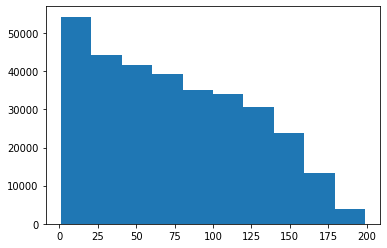

In [66]:
plt.hist(merged_df[merged_df['result'] <200].result, bins=10);

In [572]:
#import csv
merged_df = pd.read_csv('merged_treated_2000.csv', index_col=0)
participants = pd.read_csv('new_data/all_participants.csv', index_col=0).rename(columns={'rider':'name'})

merged_df = merged_df.merge(participants[['team', 'name', 'year']], on=['name', 'year'])

cum_teams = merged_df.groupby(['year','date', 'team'])[['adjusted_points']].sum().groupby(level=0).cumsum().reset_index().rename(columns={'adjusted_points': 'adjusted_team_points'})

merged_df = merged_df.merge(cum_teams[['team', 'date', 'adjusted_team_points']], on=['team', 'date'])

#add key for DB later
merged_df['key'] = merged_df['name'] + '-' + merged_df['year'].astype('str') + '-' + merged_df['race_name']

#pd date time
merged_df['date'] = pd.to_datetime(merged_df['date'])

def change_bin(x):
    if x == 0:
        return -1000.
    elif x < 21:
        return 1.
    elif x < 41:
        return 2.
    elif x < 61:
        return 3.
    elif x < 81:
        return 4.
    elif x < 101:
        return 5.
    elif x < 121:
        return 6.
    else:
        return 7
    
# def change_bin(x):
#     if x == 0:
#         return -1000.
#     elif x < 21:
#         return 1.
#     elif x < 41:
#         return 2.
#     else:
#         return 3.
    
merged_df['result_bin'] = merged_df['result'].apply(change_bin)
print(merged_df.shape)
merged_df = merged_df[merged_df['result_bin'] != -1000.]
print(merged_df.shape)

def get_types_bin(x):
    if x == 'etappe':
        return 0
    else:
        return 1
    
def icon_bin(x):
    if x == 'stage':
        return 0
    else:
        return 1
    
merged_df['types_bin'] = merged_df['type'].apply(get_types_bin)
merged_df['icon_bin'] = merged_df['icon'].apply(icon_bin)


#split to predict later
merged_df_predict = merged_df[merged_df['year'] == 2022]
merged_df_train = merged_df[merged_df['year'] != 2022]

merged_df.shape

(295735, 30)
(284042, 30)


(284042, 32)

In [573]:
merged_df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,Points scale:,Arrival:,Won how:,parcours_type_num,team,adjusted_team_points,key,result_bin,types_bin,icon_bin
1,andrey-amador,2020,etappe,2020-09-16,117,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,NaN,NaN,NaN,5.0,INEOS Grenadiers,4.732224e+09,andrey-amador-2020-tour-de-france,6.0,0,0
2,richard-carapaz,2020,etappe,2020-09-16,11,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,NaN,NaN,NaN,5.0,INEOS Grenadiers,4.732224e+09,richard-carapaz-2020-tour-de-france,1.0,0,0
3,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,NaN,NaN,NaN,5.0,INEOS Grenadiers,4.732224e+09,jonathan-castroviejo-2020-tour-de-france,6.0,0,0
4,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,NaN,NaN,NaN,5.0,INEOS Grenadiers,4.732224e+09,jonathan-castroviejo-2020-tour-de-france,6.0,0,0
5,michal-kwiatkowski,2020,etappe,2020-09-16,130,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,NaN,NaN,NaN,5.0,INEOS Grenadiers,4.732224e+09,michal-kwiatkowski-2020-tour-de-france,7.0,0,0


In [574]:
merged_df.result_bin.value_counts()/len(merged_df)

7.0    0.210289
1.0    0.174326
2.0    0.141722
3.0    0.132646
4.0    0.123031
5.0    0.114332
6.0    0.103654
Name: result_bin, dtype: float64

In [575]:
#riders to predict
riders_predict = merged_df_predict[(merged_df_predict['race_name']=='tour-de-france')| (merged_df_predict['race_name']=='vuelta-a-espana')| (merged_df_predict['race_name']=='giro-d-italia')][['name', 'year', 'race_name']]
riders_predict = riders_predict[riders_predict['year'] == 2022].drop_duplicates().reset_index(drop=True)
riders_predict

#riders to train on
riders = merged_df_train[(merged_df_train['race_name']=='tour-de-france')| (merged_df_train['race_name']=='vuelta-a-espana')| (merged_df_train['race_name']=='giro-d-italia')][['name', 'year', 'race_name']]
riders = riders[riders['year'] != 2022].drop_duplicates().reset_index(drop=True).sort_values(by='year', ascending=False)
riders

#split riders in train/test randomly
train, test = train_test_split(riders, test_size=0.2, random_state=42)

#split rediers in train/test based on years
train = riders[riders['year']<2019]
test = riders[riders['year']>=2019]

len(test)/len(train)

0.13814803715912496

In [576]:
train

,name,year,race_name
1275,valerio-conti,2018,giro-d-italia
1282,maciej-bodnar,2018,tour-de-france
1271,dan-martin,2018,vuelta-a-espana
1272,simone-petilli,2018,vuelta-a-espana
1273,darwin-atapuma,2018,giro-d-italia
...,...,...,...
3935,matthew-white,2000,giro-d-italia
3934,francesco-casagrande,2000,giro-d-italia
3933,andris-nauduzs,2000,giro-d-italia
3932,alessio-girelli,2000,giro-d-italia


In [577]:
def get_sequence(df, name, year, tour, weeks=52):
    
    #get tour data
    if year != 2000:
        tour_data = df[(df['name'] == name) & (df['year'] == year) & (df['race_name'] == tour)].sort_values(by='date')
        y_decoder = tour_data[['date', 'result_bin']].set_index('date')
        X_decoder = tour_data[['date', 'distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num']].set_index('date')
        
        season_data = df[(df['name'] == name) & (df['date'] < min(tour_data['date'])) & (df['date'] >= min(tour_data['date']) - datetime.timedelta(weeks=weeks))].sort_values(by='date')
        X_encoder = season_data[['date', 'adjusted_points','adjusted_team_points', 'result','distance', 'ProfileScore:', 'Vert. meters:', 'Startlist quality score:', 'parcours_type_num', 'icon_bin','Avg. speed winner:', 'types_bin']].set_index('date')
        performance = X_encoder.pivot_table('adjusted_points', 'date','parcours_type_num').shift(1).fillna(0).cumsum().reset_index()
        X_encoder = performance.merge(X_encoder, on='date').set_index('date').drop(columns='adjusted_points').rename(columns={1.0 : 'fl', 2.0:'hi_fl', 3.0: 'hi_hi', 4.0:'mo_fl', 5.0:'mo_mo'})
        
        for i in ['fl', 'hi_fl', 'hi_hi', 'mo_fl', 'mo_mo']:
            if i not in X_encoder.columns:
                X_encoder[i] = 0.0
                
        X_encoder = X_encoder[['fl', 'mo_fl', 'hi_fl', 'hi_hi', 'mo_mo', 'distance','result', 'adjusted_team_points', 'ProfileScore:','Vert. meters:', 'Startlist quality score:', 'parcours_type_num', 'icon_bin','Avg. speed winner:', 'types_bin']]
    
    else:
        pass
        
    return X_encoder, X_decoder, y_decoder

In [579]:
def get_scaler(maxlen, df, riders):
    
    X_encoder_ls = []
    X_decoder_ls = []
    y_ls = []


    for rider, year, tour in riders.values:
        
        if year != 2000:
            
            #X_encoder, X_decoder, y_decoder, y_encoder = get_sequence(df, rider, year, tour)
            X_encoder, X_decoder, y = get_sequence(df, rider, year, tour)
            
            X_encoder_ls.append(X_encoder)
            X_decoder_ls.append(X_decoder)
            y_ls.append(y)
            
    X_encoder_scdf = pd.concat(X_encoder_ls)
    X_decoder_scdf = pd.concat(X_decoder_ls)
    y_train_scdf = pd.concat(y_ls)
    
    X_enc_mm = MinMaxScaler()
    X_enc_mm.fit(X_encoder_scdf)
    
    X_dec_mm = MinMaxScaler()
    X_dec_mm.fit(X_decoder_scdf)
    
    #y_train_mm = MinMaxScaler()
    #y_train_mm.fit(y_train_scdf)

            
    return X_enc_mm, X_dec_mm#, y_train_mm

X_enc_mm, X_dec_mm = get_scaler(40, merged_df, train)

In [580]:
missing_ls = []

def get_sequences(maxlen, df, riders):
    
    X_encoder_ls = []
    X_decoder_ls = []
    #y_encoder_ls = []
    y_decoder_ls = []
    
    i=0


    for rider, year, tour in riders.values:
        
        if year != 2000:
            
                #print(rider, year, tour)
            
            #try:
            
                X_encoder, X_decoder, y_decoder = get_sequence(df, rider, year, tour)
                #X_encoder, X_decoder, y_decoder, y_encoder = get_sequence(df, rider, year, tour)
                
                if X_encoder.shape == (0,15):
                    print(rider, year, tour, X_encoder.shape)
                    missing_ls.append([rider, year, tour])
                
                else:
                    X_encoder = X_enc_mm.transform(X_encoder)
                    X_decoder = X_dec_mm.transform(X_decoder)
                    #y = y_train_mm.transform(y_decoder)
                    
                    X_encoder_pad = pad_sequences(X_encoder.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                    #y_encoder_pad = pad_sequences(y_encoder.to_numpy().T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                    
                    X_decoder_pad = pad_sequences(X_decoder.T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                    y_decoder_pad = pad_sequences(y_decoder.to_numpy().T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                    #X_decoder_pad = pad_sequences(X_decoder_pad.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                    
                    #y_decoder_pad = pad_sequences(y_decoder.T, maxlen=21, dtype='float', padding='post', value=-1000.).T
                    #y_pad = pad_sequences(y_decoder_pad.T, maxlen=maxlen, dtype='float', padding='pre', value=-1000.).T
                        
                    X_encoder_ls.append(X_encoder_pad)
                    X_decoder_ls.append(X_decoder_pad)
                    #y_encoder_ls.append(y_encoder_pad)
                    y_decoder_ls.append(y_decoder_pad)
                    #y_ls.append(y_pad)
                    
                    #print(X_encoder_pad.shape, X_decoder_pad.shape, y_pad.shape)
                
                #except ValueError:
                    #i+=1
                    #print(f"ValueError for {i, rider, year, tour}")
    
    return np.array(X_encoder_ls), np.array(X_decoder_ls), np.array(y_decoder_ls)

In [581]:
# split data in train/test/predict
X_encoder_train, X_decoder_train, y_decoder_train = get_sequences(40, merged_df, train)
X_encoder_test, X_decoder_test, y_decoder_test = get_sequences(40, merged_df, test)
X_encoder_predict, X_decoder_predict, y_decoder_predict = get_sequences(40, merged_df_predict, riders_predict)

julien-morice 2016 vuelta-a-espana (0, 15)
silvio-herklotz 2016 vuelta-a-espana (0, 15)
gang-xu 2015 giro-d-italia (0, 15)
alessandro-malaguti 2015 giro-d-italia (0, 15)
riccardo-stacchiotti 2015 giro-d-italia (0, 15)
matteo-busato 2015 giro-d-italia (0, 15)
eduard-michael-grosu 2015 giro-d-italia (0, 15)
alessandro-bisolti 2015 giro-d-italia (0, 15)
gianfranco-zilioli 2015 giro-d-italia (0, 15)
tiziano-dall-antonia 2015 giro-d-italia (0, 15)
giacomo-berlato 2015 giro-d-italia (0, 15)
nikolay-mihaylov 2015 giro-d-italia (0, 15)
kenneth-van-bilsen 2015 tour-de-france (0, 15)
dan-craven 2014 vuelta-a-espana (0, 15)
philip-deignan 2014 giro-d-italia (0, 15)
elia-viviani 2014 giro-d-italia (0, 15)
daniel-oss 2014 giro-d-italia (0, 15)
brent-bookwalter 2014 giro-d-italia (0, 15)
julien-berard 2014 giro-d-italia (0, 15)
arnaud-courteille 2014 giro-d-italia (0, 15)
giorgio-cecchinel 2014 giro-d-italia (0, 15)
jean-marc-bideau 2014 tour-de-france (0, 15)
arnaud-gerard 2014 tour-de-france (0, 1

In [582]:
pd.DataFrame(missing_ls, columns=['rider', 'year', 'tour']).to_csv('new_data/missing_riders.csv')

In [583]:
y_decoder_train[y_decoder_train < 1.] = 0
y_decoder_test[y_decoder_test < 1.] = 0
y_decoder_predict[y_decoder_predict < 1.] = 0

In [584]:
y_decoder_train_pad = to_categorical(y_decoder_train, num_classes=8)
y_decoder_train_test = to_categorical(y_decoder_test, num_classes=8)
y_decoder_train_predict = to_categorical(y_decoder_predict, num_classes=8)

In [585]:
X_encoder_train.shape

(5027, 40, 15)

In [611]:
# define the encoder and decoder -> clean
def encoder(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    #each LSTM unit returning a sequence of 6 outputs, one for each time step in the input data
    y = LSTM(units=30, return_sequences=True, activation='tanh')(y)
    y = LSTM(units=15, return_sequences=True, activation='tanh')(y)
    #output one time step from the sequence for each time step in the input but process 5 outputs of the input sequence at a time
    #y = TimeDistributed(Dense(units=5, activation='tanh'))(y)
    y = LSTM(units=15, return_sequences=False, activation='tanh')(y)
    y = RepeatVector(21)(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = 0.)(x)
    x = TimeDistributed(Dense(units=32, activation='relu'))(x)
    x = TimeDistributed(Dense(units=16, activation='relu'))(x)
    x = TimeDistributed(Dense(units=6, activation='relu'))(x)
    y = TimeDistributed(Dense(units=8, activation='softmax'))(x)
    return y

In [612]:
# build the model -> clean
encoder_features = Input(shape=X_encoder_train.shape[1:])
decoder_features = Input(shape=X_decoder_train.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

In [613]:
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 40, 15)]     0           []                               
                                                                                                  
 masking_68 (Masking)           (None, 40, 15)       0           ['input_69[0][0]']               
                                                                                                  
 lstm_102 (LSTM)                (None, 40, 30)       5520        ['masking_68[0][0]']             
                                                                                                  
 lstm_103 (LSTM)                (None, 40, 15)       2760        ['lstm_102[0][0]']               
                                                                                           

In [614]:
X_encoder_train.shape, X_decoder_train.shape

((5027, 40, 15), (5027, 21, 5))

In [615]:
# train the model
metric = RootMeanSquaredError()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[metric])


es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)

history = model.fit([X_encoder_train, X_decoder_train], y_decoder_train_pad, epochs=1000000, 
                    batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)#, class_weight=class_weights)

Epoch 1/1000000
28/28 [==============================] - 12s 210ms/step - loss: 2.9287 - accuracy: 0.1118 - val_loss: 3.8294 - val_accuracy: 0.1122
Epoch 2/1000000
28/28 [==============================] - 1s 54ms/step - loss: 2.9203 - accuracy: 0.1165 - val_loss: 3.8240 - val_accuracy: 0.1181
Epoch 3/1000000
28/28 [==============================] - 1s 51ms/step - loss: 2.9133 - accuracy: 0.1251 - val_loss: 3.8191 - val_accuracy: 0.1329
Epoch 4/1000000
28/28 [==============================] - 1s 52ms/step - loss: 2.9062 - accuracy: 0.1311 - val_loss: 3.8117 - val_accuracy: 0.1352
Epoch 5/1000000
28/28 [==============================] - 1s 52ms/step - loss: 2.8959 - accuracy: 0.1303 - val_loss: 3.8006 - val_accuracy: 0.1359
Epoch 6/1000000
28/28 [==============================] - 1s 53ms/step - loss: 2.8832 - accuracy: 0.1306 - val_loss: 3.7896 - val_accuracy: 0.1360
Epoch 7/1000000
28/28 [==============================] - 1s 52ms/step - loss: 2.8713 - accuracy: 0.1306 - val_loss: 3.7799

In [617]:
#model.evaluate([X_encoder_test, X_decoder_test], y_decoder_train_test)
model.evaluate([X_encoder_test, X_decoder_test], y_decoder_train_test)

29/29 [==============================] - 0s 8ms/step - loss: 3.0944 - accuracy: 0.2157


[3.094414472579956, 0.21570757031440735]

[3.002560615539551, 0.2746497094631195]

In [618]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [646]:

#model.save('models/model_best')
model = load_model('models/model_best')

2022-08-09 20:55:24.860883: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-09 20:55:24.873210: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-09 20:55:25.165018: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-09 20:55:25.815850: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-08-09 20:55:26.335340: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

In [647]:
preds = model.predict([X_encoder_predict, X_decoder_predict])

In [663]:
pred_ls = []

for pred, rid in zip(preds, riders_predict.values):
    pred_ls.append(np.append(pred[:,1].round(3), rid))

In [622]:
pred_ls = []

for pred, rid in zip(preds, riders_predict.values):
    pred_ls.append(np.append(pred, rid))
    

In [664]:
pred_df = pd.DataFrame(pred_ls).replace(1.000, np.nan)
#pred_df = pd.DataFrame(pred_ls)#.replace(1.000, np.nan)

In [665]:
pred_tdf = pred_df[pred_df[23]=='tour-de-france']

In [667]:
pred_tdf.sort_values(by=3, ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
155,0.663,0.455,0.475,0.450,0.518,0.167,0.073,0.194,0.134,0.088,...,0.280,0.097,0.069,0.054,0.238,0.456,0.559,mads-pedersen,2022,tour-de-france
13,0.646,0.443,0.465,0.443,0.501,0.164,0.073,0.191,0.132,0.088,...,0.276,0.096,0.068,0.056,0.228,0.441,0.542,wout-van-aert,2022,tour-de-france
34,0.367,0.277,0.285,0.302,0.290,0.329,0.412,0.343,0.382,0.413,...,0.317,0.397,0.459,0.476,0.320,0.389,0.312,aleksandr-vlasov,2022,tour-de-france
67,0.349,0.263,0.272,0.288,0.278,0.325,0.409,0.334,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,guillaume-martin,2022,tour-de-france
94,0.430,0.285,0.296,0.284,0.318,0.201,0.165,0.206,0.200,0.175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mathieu-van-der-poel,2022,tour-de-france
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.166,0.061,0.065,0.066,0.073,0.060,0.078,0.066,0.070,0.083,...,0.060,0.075,0.094,0.093,0.061,0.096,0.090,anthony-perez,2022,tour-de-france
18,0.153,0.061,0.066,0.065,0.075,0.056,0.066,0.061,0.063,0.072,...,0.058,0.066,0.081,0.080,0.057,0.091,0.090,jonathan-castroviejo,2022,tour-de-france
87,0.155,0.060,0.064,0.065,0.071,0.061,0.080,0.067,0.072,0.085,...,0.062,0.078,0.097,0.096,0.062,0.095,0.085,michael-storer,2022,tour-de-france
185,0.152,0.058,0.063,0.061,0.072,0.045,0.044,0.051,0.049,0.050,...,0.050,0.048,0.054,0.052,0.049,0.086,0.087,christopher-juul-jensen,2022,tour-de-france


In [669]:
pred_tdf[pred_tdf[21] == 'danny-van-poppel']

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
41,0.347,0.12,0.134,0.127,0.166,0.045,0.027,0.055,0.041,0.031,...,0.07,0.034,0.028,0.025,0.064,0.159,0.207,danny-van-poppel,2022,tour-de-france


In [655]:
riders_ls = []

for i in range(0,21):
    riders_ls.append(pred_tdf.sort_values(by=i, ascending=False).head(20)[21])
    
riders_ls = [item for sublist in riders_ls for item in sublist]

In [656]:
pd.DataFrame(riders_ls).value_counts()[0:60]

daniel-felipe-martinez        20
aleksandr-vlasov              20
brandon-mcnulty               20
nairo-quintana                18
giulio-ciccone                17
jonas-vingegaard-rasmussen    16
enric-mas                     16
adam-yates                    15
tadej-pogacar                 15
ion-izagirre                  15
bauke-mollema                 13
primoz-roglic                 12
mads-pedersen                 12
wout-van-aert                 12
david-gaudu                   11
damiano-caruso                11
jakob-fuglsang                10
pierre-latour                 10
lennard-kamna                 10
matej-mohoric                 10
fabio-jakobsen                 8
mathieu-van-der-poel           8
jasper-philipsen               7
christophe-laporte             7
guillaume-martin               7
warren-barguil                 7
jasper-stuyven                 7
romain-bardet                  7
dylan-teuns                    7
alfred-wright                  7
caleb-ewan